<a href="https://colab.research.google.com/github/Shehab37/gans/blob/main/tf_dcgan_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from PIL import Image
import time
import gc

In [ ]:
# i put the celeba dataset in a zip file 
! unzip /content/drive/MyDrive/CelebA/Img/img_align_celeba.zip -d celeba

In [24]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
 '/content/celeba',
  seed=123,
  image_size=(112, 112),
  batch_size=512,
  shuffle = True)

Found 202599 files belonging to 1 classes.


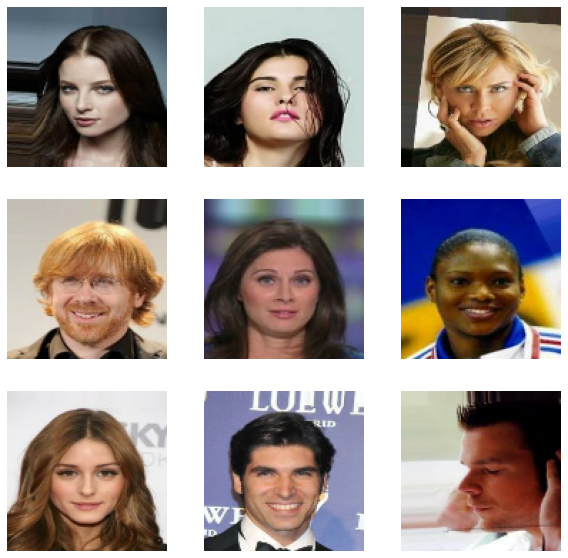

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

-1.0 1.0


In [10]:
# AUTOTUNE = tf.data.AUTOTUNE
# normalized_ds = normalized_ds.prefetch(buffer_size=AUTOTUNE)

In [33]:
batch_size = 512

In [11]:
codings_size = 128
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),

])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[112, 112, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

In [23]:
opt = keras.optimizers.Adam(learning_rate=0.0002,beta_1 = 0.5,beta_2=0.999)


discriminator.compile(loss="binary_crossentropy", optimizer=opt)
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=opt)

In [13]:
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              809088    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        2

In [14]:
def plot_images(imgs):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
  plt.show()

In [ ]:
### just for checking the plot_images function
# noise = tf.random.normal(shape=[batch_size, codings_size])
# generated_images = generator(noise)
# generated_images = ((generated_images+1)/2.0)*255.0
# generated_images = tf.cast(tf.reshape(generated_images, (batch_size,112,112,3)),tf.int32)
# plot_images(generated_images)

In [31]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
  batch_num = 0
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print("\n Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
    for X_batch, _ in tqdm(dataset):
      # training the discriminator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      # training the generator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    # for ploting the generated images

      batch_num += 1
      if batch_num % 50 == 0:
        generated_images = ((generated_images+1)/2.0)*255.0
        generated_images = tf.cast(tf.reshape(generated_images, (batch_size,112,112,3)),tf.int32)
        plot_images(generated_images)
        # gc.collect()




In [ ]:
train_gan(gan, normalized_ds, batch_size, codings_size,n_epochs = 1)